In [1]:
from HSI_utils import *
import torch
from vit import *
from mae import *
from sklearn import metrics

In [2]:
seed = 23

torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
PATCH_SIZE = 10
EPOCHS = 2500
loss = 'mse'
batch_size = 1
# loss = 'weighted_l2'
# loss = 'mae'
TRAIN = True
LOAD = False
PCA = 0
dim_enc = 128
dim_dec = 128
id_img = 0

In [4]:
ruta = os.path.join("data")
df_files = create_df_from_files_in_path(ruta, verbose = True)

Reading file names from data...
         Filename Format               Path  Height  Width  Layers
0   abu-airport-1    mat  abu-airport-1.mat     100    100     205
1   abu-airport-2    mat  abu-airport-2.mat     100    100     205
2   abu-airport-3    mat  abu-airport-3.mat     100    100     205
3   abu-airport-4    mat  abu-airport-4.mat     100    100     191
4     abu-beach-1    mat    abu-beach-1.mat     150    150     188
5     abu-beach-2    mat    abu-beach-2.mat     100    100     193
6     abu-beach-3    mat    abu-beach-3.mat     100    100     188
7     abu-beach-4    mat    abu-beach-4.mat     150    150     102
8     abu-urban-1    mat    abu-urban-1.mat     100    100     204
9     abu-urban-2    mat    abu-urban-2.mat     100    100     207
10    abu-urban-3    mat    abu-urban-3.mat     100    100     191
11    abu-urban-4    mat    abu-urban-4.mat     100    100     205
12    abu-urban-5    mat    abu-urban-5.mat     100    100     205


In [5]:
# auxiliar functions
def reconstruct_patch(patch_vector):
    rec_patch = torch.zeros((PATCH_SIZE, PATCH_SIZE, layers))
    for patch_pixel in range(PATCH_SIZE**2):
        id_pixel = 0
        for row in range(PATCH_SIZE):
            for column in range(PATCH_SIZE):
                rec_patch[row, column, :] = patch_vector[id_pixel*layers:(id_pixel+1)*layers]
                id_pixel += 1
    return rec_patch

def iterative_gaussian_blur(image, n_iters = 5, var = 1):
  for i in range(n_iters):
    image = cv2.GaussianBlur(image, (3,3), var)
  return norm_img(image) 

>> Processing image abu-airport-1...
Reading HSI image from data\abu-airport-1.mat...
Hypercube abu-airport-1 data structure generated with dimensions 100x100x205.
Anomaly map data structure generated with dimensions 100x100.
>> Model for abu-airport-1 created.
Image abu-airport-1 reconstructed.


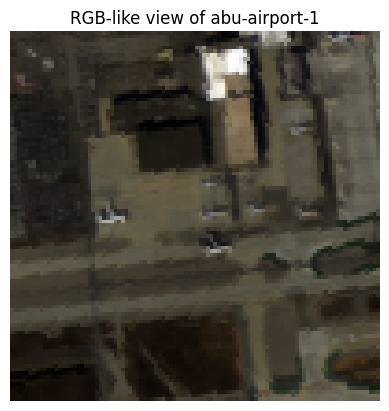

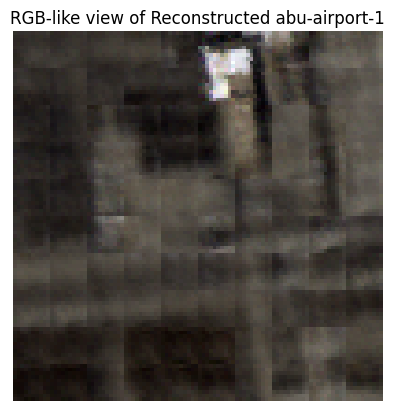

In [6]:
# TEST 

# for id_img in df_files.index:

name = df_files.Filename[id_img]
print(f'>> Processing image {name}...')
# Prepare dataset (HSI)
layers = df_files.Layers[id_img]
height = df_files.Height[id_img]
width = df_files.Width[id_img]
x_n = torch.zeros(1, layers, height, width)
anomaly_map, hs_image = load_HSI_from_idx(id_img, df_files, verbose = True)
hs_image = norm_img(hs_image)
if PCA > 0:
  hs_image = reduce_HSI_dim_with_PCA(hs_image, PCA)
  hs_image = norm_img(hs_image)
# print_RGB_HSI(hs_image, img_name = name)
# print(f'Image under test with dimmensions {np.shape(hs_image)}')
x_i = torch.from_numpy(np.float32(hs_image.copy()))
x_i = torch.permute(x_i, (2, 0, 1))
x_n[0,:,:] = x_i
# Create the ViT encoder
v = ViT(
    image_size = height,
    patch_size = PATCH_SIZE,
    channels = layers,
    num_classes = 1,
    dim = dim_enc,
    depth = 16,
    heads = 8,
    mlp_dim = 32,
    emb_dropout = 0,
    pool = 'mean',
    verbose = 1
)
# Create the Masked Autoencoder model
mae = MAE(
    encoder = v,
    masking_ratio = 0.7,   
    decoder_dim = dim_dec,     
    decoder_depth = 16,       # anywhere from 1 to 8
    decoder_heads = 8,
    decoder_dim_head = 32,
    lr = 5e-4,
    verbose = 1
)
print(f'>> Model for {name} created.')
# print(v)
# print(mae)
# load previous weights for the model
mae.load_state_dict(torch.load("models_mse_2000_epochs/"+ name + '_2000mse.pth'))
df_history = pd.read_csv('./models_mse_2000_epochs/training_losses_2000mse_' + name + '.csv')
mae.loss_history = df_history.MSE.values.tolist()

# Reconstruct the image
reconstructed_img = mae.reconstruct_image(x_n)
# Reorganization of the reconstructed image
x_hat = torch.zeros((height, width, layers))
rec_img = reconstructed_img[0,:]
id_patch = 0
for row in range(int(height/PATCH_SIZE)):
    for column in range(int(width/PATCH_SIZE)):
        patch_vector = rec_img[id_patch, :]
        patch = reconstruct_patch(patch_vector)
        x_hat[row*PATCH_SIZE:(row+1)*PATCH_SIZE, column*PATCH_SIZE:(column+1)*PATCH_SIZE, :] = patch
        id_patch += 1
img = x_hat.detach().numpy()
img = norm_img(img)
print(f'Image {name} reconstructed.')

print_RGB_HSI(hs_image, img_name = name)
print_RGB_HSI(img, img_name = 'Reconstructed ' + name)

>> Processing image abu-airport-1...
Reading HSI image from data\abu-airport-1.mat...
Hypercube abu-airport-1 data structure generated with dimensions 100x100x205.
Anomaly map data structure generated with dimensions 100x100.


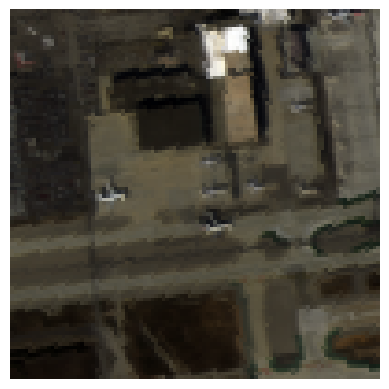

>> Model for abu-airport-1 created.
Size of encoded_image: torch.Size([1, 100, 20500])
(100, 100, 205)
Image abu-airport-1 reconstructed.


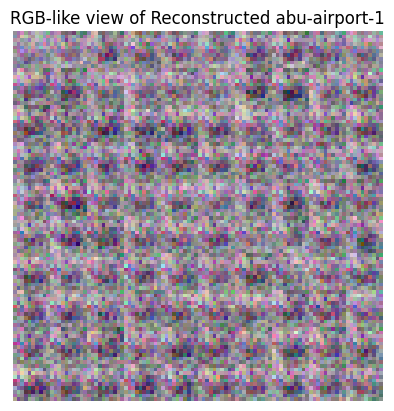

In [11]:
# Encode with MAE and AD with SVM

name = df_files.Filename[id_img]
print(f'>> Processing image {name}...')
# Prepare dataset (HSI)
layers = df_files.Layers[id_img]
height = df_files.Height[id_img]
width = df_files.Width[id_img]
x_n = torch.zeros(1, layers, height, width)
anomaly_map, hs_image = load_HSI_from_idx(id_img, df_files, verbose = True)
hs_image = norm_img(hs_image)

print_RGB_HSI(hs_image)

if PCA > 0:
  hs_image = reduce_HSI_dim_with_PCA(hs_image, PCA)
  hs_image = norm_img(hs_image)

x_i = torch.from_numpy(np.float32(hs_image.copy()))
x_i = torch.permute(x_i, (2, 0, 1))
x_n[0,:,:] = x_i

# Create the ViT encoder
v = ViT(
    image_size = height,
    patch_size = PATCH_SIZE,
    channels = layers,
    num_classes = 1,
    dim = dim_enc,
    depth = 16,
    heads = 8,
    mlp_dim = 32,
    emb_dropout = 0,
    pool = 'mean',
    verbose = 1
)
# Create the Masked Autoencoder model
mae = MAE(
    encoder = v,
    masking_ratio = 0.7,   
    decoder_dim = dim_dec,     
    decoder_depth = 16,       # anywhere from 1 to 8
    decoder_heads = 8,
    decoder_dim_head = 32,
    lr = 5e-4,
    verbose = 1
)
print(f'>> Model for {name} created.')

# load previous weights for the model
mae.load_state_dict(torch.load("models_mse_2000_epochs/"+ name + '_2000mse.pth'))
df_history = pd.read_csv('./models_mse_2000_epochs/training_losses_2000mse_' + name + '.csv')
mae.loss_history = df_history.MSE.values.tolist()

# Encode the image
mae.eval()
encoded_image = mae.encode_image(x_n)
print(f'Size of encoded_image: {encoded_image.size()}')

# RECONSTRUCTION WITH PATCH SIZE >1
x_hat = torch.zeros((height, width, layers))
rec_img = encoded_image[0,:]
id_patch = 0
for row in range(int(height/PATCH_SIZE)):
    for column in range(int(width/PATCH_SIZE)):
        patch_vector = rec_img[id_patch, :]
        patch = reconstruct_patch(patch_vector)
        x_hat[row*PATCH_SIZE:(row+1)*PATCH_SIZE, column*PATCH_SIZE:(column+1)*PATCH_SIZE, :] = patch
        id_patch += 1
   
img = x_hat.detach().numpy()
img = norm_img(img)
print(np.shape(img))

print(f'Image {name} reconstructed.')

# print_RGB_HSI(hs_image, img_name = name)
print_RGB_HSI(img, img_name = 'Reconstructed ' + name)

In [12]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

Reading HSI image from data\abu-airport-1.mat...
Hypercube abu-airport-1 data structure generated with dimensions 100x100x205.
Anomaly map data structure generated with dimensions 100x100.


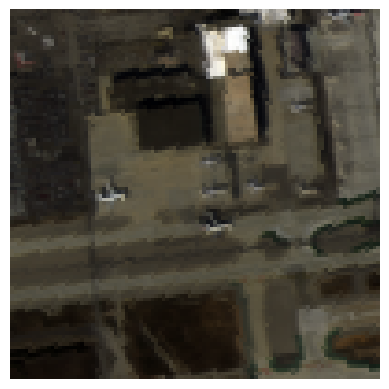

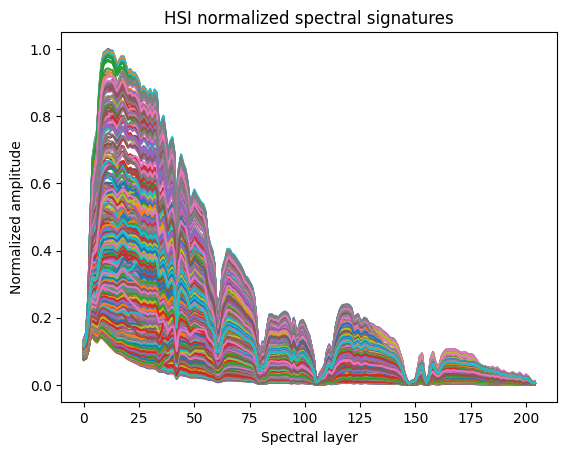

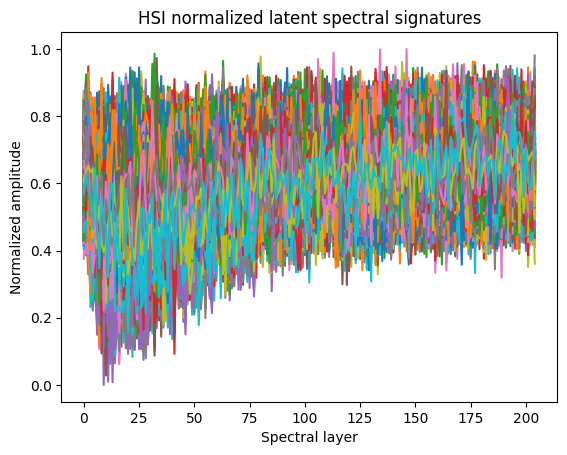

In [14]:
anomaly_map, hs_image = load_HSI_from_idx(id_img, df_files, verbose = True)
hs_image = norm_img(hs_image)

height = df_files.Height[id_img]
width = df_files.Width[id_img]
layers = df_files.Layers[id_img]

print_RGB_HSI(hs_image)

x = hs_image.reshape(height*width,layers)
x_encoded = img.reshape(height*width,layers)

plt.figure()
plt.plot(np.transpose(x))
plt.title('HSI normalized spectral signatures')
plt.xlabel('Spectral layer')
plt.ylabel('Normalized amplitude')
plt.show()

plt.figure()
plt.plot(np.transpose(x_encoded))
plt.title('HSI normalized latent spectral signatures')
plt.xlabel('Spectral layer')
plt.ylabel('Normalized amplitude')
plt.show()

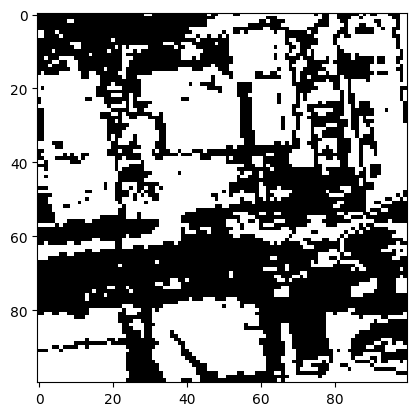

In [15]:
# SVM over the original image
clf = OneClassSVM(gamma='auto').fit(x)
predictions = clf.predict(x)

pred_pixels = norm_img(predictions.reshape(height,width))
plt.imshow(1-pred_pixels, cmap= plt.cm.gray)

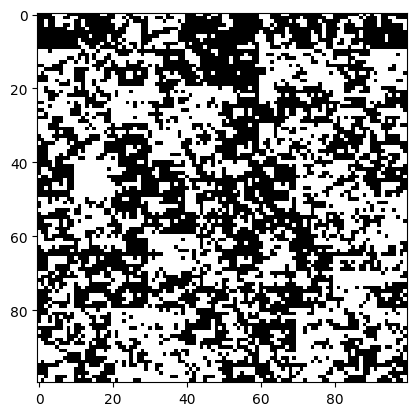

In [16]:
# SVM over the encoded image
clf_enc = OneClassSVM(gamma='auto').fit(x_encoded)
predictions_enc = clf_enc.predict(x_encoded)

pred_pixels_enc = norm_img(predictions_enc.reshape(height,width))
plt.imshow(1-pred_pixels_enc, cmap= plt.cm.gray)

In [17]:
import random


def min_iterations(n, sample_rate, target):
    observed = set() # conjunto de índices de datos observados
    samples = 0
    while len(observed) < np.ceil(target * n):
        # Muestreamos según el ratio indicado
        i = random.sample(range(n), int(np.ceil(n * sample_rate)))
        # Añadimos las observaciones al set
        for observation in i:
            observed.add(observation)
        samples += 1
        # print(len(observed))
    return samples # número de iteraciones realizadas

# Ejemplo de uso:
n = 10000 # tamaño del conjunto de datos
sample_rate = 0.3
target = 1

n_iters = 10000
print(f'Simulando mediante Monte Carlo con {n_iters} iteraciones...')
iters = []
for monte_carlo_iter in range(n_iters):
    iters.append(min_iterations(n, sample_rate, target))

avg = np.mean(iters)
std = np.std(iters)
# i = min_iterations(n, sample_rate, target)
print(f"El número mínimo de iteraciones necesarias para observar al menos el {target*100}% de los datos es: {avg}, con desviación estándar: {std}")

Simulando mediante Monte Carlo con 10000 iteraciones...


KeyboardInterrupt: 

In [ ]:
# Ejemplo de uso:
n = 10000 # tamaño del conjunto de datos
sample_rate = 0.3
target = 0.95

n_iters = 100
print(f'Simulando mediante Monte Carlo con {n_iters} iteraciones...')
iters = []
for monte_carlo_iter in range(n_iters):
    iters.append(min_iterations(n, sample_rate, target))

avg = np.mean(iters)
std = np.std(iters)
# i = min_iterations(n, sample_rate, target)
print(f"El número mínimo de iteraciones necesarias para observar al menos el {target*100}% de los datos es: {avg}, con desviación estándar: {std}")

Simulando mediante Monte Carlo con 100 iteraciones...
El número mínimo de iteraciones necesarias para observar al menos el 95.0% de los datos es: 9.0, con desviación estándar: 0.0
